# Stroke Prediction

<p style='text-align: justify;'>
According to the <a href="https://www.who.int/">World Health Organization (WHO)</a>, <a href="https://en.wikipedia.org/wiki/Stroke">stroke</a> is the 2nd leading cause of death globally, responsible for approximately 11% of total deaths. Even though it sounds quite deadly, yet up to 80% of strokes can be prevented with a combination of medication and healthy habits. A stroke occurs when the blood supply to part of your brain is interrupted or reduced, preventing brain tissue from getting oxygen and nutrients. Brain cells begin to die in minutes. Early action can reduce brain damage and other complications. Effective treatments can also help prevent disability from stroke.
</p>

Our goal is to understand what are the reasons that cause stroke and see if we can successfully detect it using Machine Learning.

## *Table of Contents*

- [*1. Introduction*](#introduction)
    - [*1.1. Libraries*](#libraries)
    - [*1.2. Data Collection*](#data_collection)
- [*2. Data Cleansing*](#data_cleansing)
- [*3. Exploratory Data Analysis*](#eda)
    - [*3.1. Target Variable Distribution*](#target_variable_distribution)
    - [*3.2. Feature Distributions (vs Target Variable)*](#feature_distributions)
    - [*3.3. Pairwise Feature Correlation*](#pairwise_feature_correlation)
    - [*3.4. Feature Significance*](#feature_significance)
- [*4. Data Preprocessing*](#data_preprocessing)
    - [*4.1. One-Hot Encoding*](#ohe)
    - [*4.2. Train Test Split*](#train_test_split)
    - [*4.3. Handle Missing Values*](#handle_missing_values)
- [*5. Feature Engineering*](#feature_engineering)
    - [*5.1. Feature Scaling*](#feature_scaling)
    - [*5.2. Handle Class Imbalance*](#handle_class_imbalance)
- [*6. Modeling*](#modeling)
    - [*6.1 Cross Validation*](#cross_validation)
    - [*6.2 GridSearchCV*](#grid_search_cv)
    - [*6.3 Predictions (on test set)*](#predictions)
- [*7. Conclusion*](#conclusion)

---

## Introduction <a class='anchor' id='introduction'></a>

### *Libraries* <a class='anchor' id='libraries'></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from datetime import datetime

import scipy.stats.stats as stats
import statsmodels.formula.api as smf
from scipy.stats import shapiro

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SVMSMOTE

from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report

import warnings
warnings.filterwarnings('ignore')

### *Data Collection* <a class='anchor' id='data_collection'></a>

- The dataset were acquired from [kaggle.com](https://www.kaggle.com/fedesoriano/stroke-prediction-dataset)

##### *Read the data*

In [2]:
df = pd.read_csv('./data/healthcare_dataset_stroke.csv')

In [3]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [4]:
df.shape

(5110, 12)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


## Data Cleansing <a class='anchor' id='data_cleansing'></a>

- Before we proceed with the next steps, we need first to clean our data

##### *Handle `gender` column*

In [6]:
df.gender.value_counts()

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64

##### *Drop that single row where `gender = Other`*

In [7]:
df = df[~(df.gender == 'Other')]

##### *Handle `work_type` column*

In [8]:
df.work_type.value_counts()

Private          2924
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64

- Some people in our data have defined their `work_type` value as `Never_worked`
- This group of people is very small, so let's investigate those included in it and see if we can put them in another group

In [9]:
df[df.work_type == 'Never_worked']

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
253,46136,Male,14.0,0,0,No,Never_worked,Rural,161.28,19.1,Unknown,0
603,61408,Male,23.0,0,0,No,Never_worked,Urban,125.26,18.7,never smoked,0
886,13948,Female,19.0,0,0,No,Never_worked,Urban,86.96,25.8,never smoked,0
939,16556,Male,13.0,0,0,No,Never_worked,Rural,111.48,20.8,Unknown,0
959,56986,Male,17.0,0,0,No,Never_worked,Urban,113.25,23.4,never smoked,0
1462,41870,Male,17.0,0,0,No,Never_worked,Rural,61.01,32.5,Unknown,0
1789,13862,Female,13.0,0,0,No,Never_worked,Urban,70.93,22.9,never smoked,0
1922,51935,Male,16.0,0,0,No,Never_worked,Urban,59.99,28.2,never smoked,0
2346,61219,Female,14.0,0,0,No,Never_worked,Urban,148.37,22.7,never smoked,0
2721,23508,Female,17.0,0,0,No,Never_worked,Rural,88.57,31.1,never smoked,0


In [10]:
# list with ages of those who have never worked
never_worked = df[df.work_type == 'Never_worked'].age

# percentage of young under 20
young = len(list([age for age in never_worked if age < 20])) / len(never_worked) * 100

# result
print(f'Those who have never worked have an average age of {never_worked.mean():.3}, and {young:.3}% of them are under 20.')

Those who have never worked have an average age of 16.2, and 95.5% of them are under 20.


- Seems that those 22 people who have never worked are either kids or young people
- Therefore, we will change their `work_type` value and put them under the `children` category

##### *Convert `Never_worked` to `children`*

In [11]:
df.work_type = df.work_type.apply(lambda x: 'children' if x.strip().lower() == 'never_worked' else x.strip().lower())

##### *Save the cleaned data*

In [12]:
df.to_csv('./data/healthcare_dataset_stroke_cleaned.csv', index=False)

## EDA <a class='anchor' id='eda'></a>

- In this section, we will try to understand the relationship between different features and our target variable
- Moreover, we will use inferential statistic methods to study how different features influence the occurence of stroke

### *Target Variable Distribution* <a class='anchor' id='target_variable_distribution'></a>

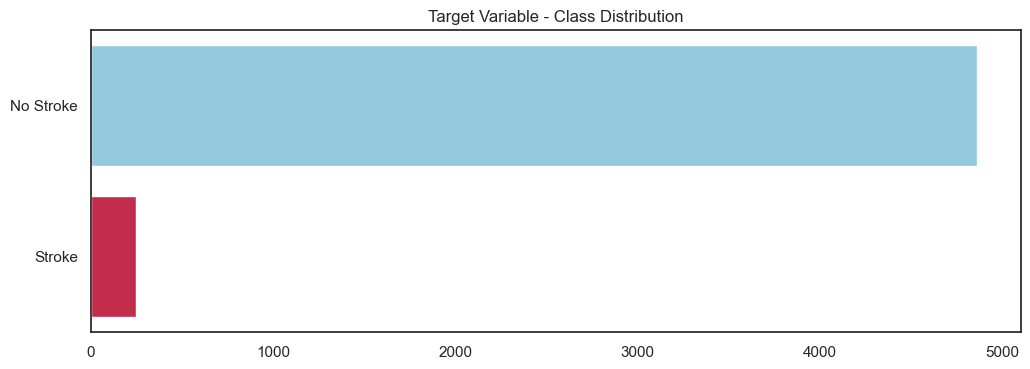

				 Only 4.9% of the people in the dataset had a stroke incidence.


In [13]:
# set style
sns.set_theme(style='white')

# create figure
plt.figure(figsize=(12,4), dpi=100, facecolor='white')

# plot
sns.countplot(data=df, y=df.stroke, palette=['skyblue','crimson'])

# params
plt.xlabel(None)
plt.ylabel(None)
plt.yticks(ticks=[0,1], labels=['No Stroke', 'Stroke'])
plt.title('Target Variable - Class Distribution')
plt.savefig('./images/class_distribution.svg')
plt.show()

print(f'\t\t\t\t Only {df.stroke.sum() / len(df) * 100:.2}% of the people in the dataset had a stroke incidence.')

- This is something that we actually expected
- Our dataset is highly imbalanced, with only 5% of the people having experienced a stroke
- This imbalance can have a strong negative impact in our predictions
- In order to avoid false predictions, we will handle this issue at a later stage

### *Feature Distributions (vs Target Variable)* <a class='anchor' id='feature_distributions'></a>

##### *Create interim dataframes including only those who have / haven't experienced a stroke*

In [14]:
stroke_y = df[df.stroke == 1]
stroke_n = df[df.stroke == 0]

##### *Plot work type and smoking status*

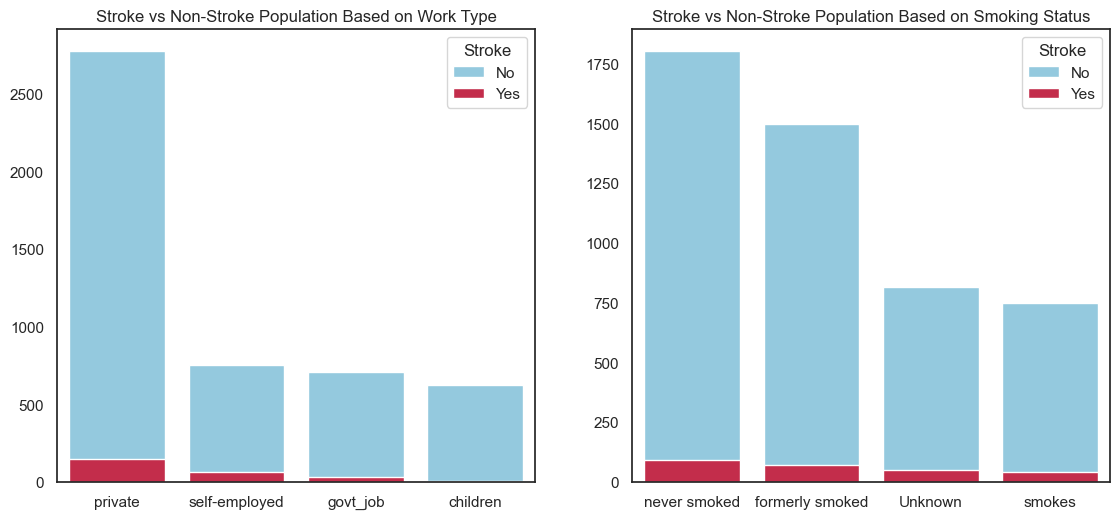

In [15]:
fig, ax = plt.subplots(1,2, figsize=(12,6), dpi=100, facecolor='white')

sns.countplot(x=stroke_n.work_type, order=stroke_n.work_type.value_counts().index, color='skyblue', label='No', ax=ax[0])
sns.countplot(x=stroke_y.work_type, order=stroke_y.work_type.value_counts().index, color='crimson', label='Yes', ax=ax[0])
ax[0].set_xlabel(None)
ax[0].set_ylabel(None)
ax[0].set_title('Stroke vs Non-Stroke Population Based on Work Type')
ax[0].legend(title='Stroke')

sns.countplot(x=stroke_n.smoking_status, order=stroke_n.smoking_status.value_counts().index, color='skyblue', label='No', ax=ax[1])
sns.countplot(x=stroke_y.smoking_status, order=stroke_y.smoking_status.value_counts().index, color='crimson', label='Yes', ax=ax[1])
ax[1].set_xlabel(None)
ax[1].set_ylabel(None)
ax[1].set_title('Stroke vs Non-Stroke Population Based on Smoking Status')
ax[1].legend(title='Stroke')

fig.tight_layout(pad=3)
fig.savefig('./images/work_type_smoking_status_stroke.svg')
fig.show()

- According to the graphs, the work type does not seem to affect the occurrence of a stroke
- Also, surprisingly, in contrast to what we might have expected, smoking status does not seem to be correlated with the occurrence of a stroke

##### *Plot demographics*

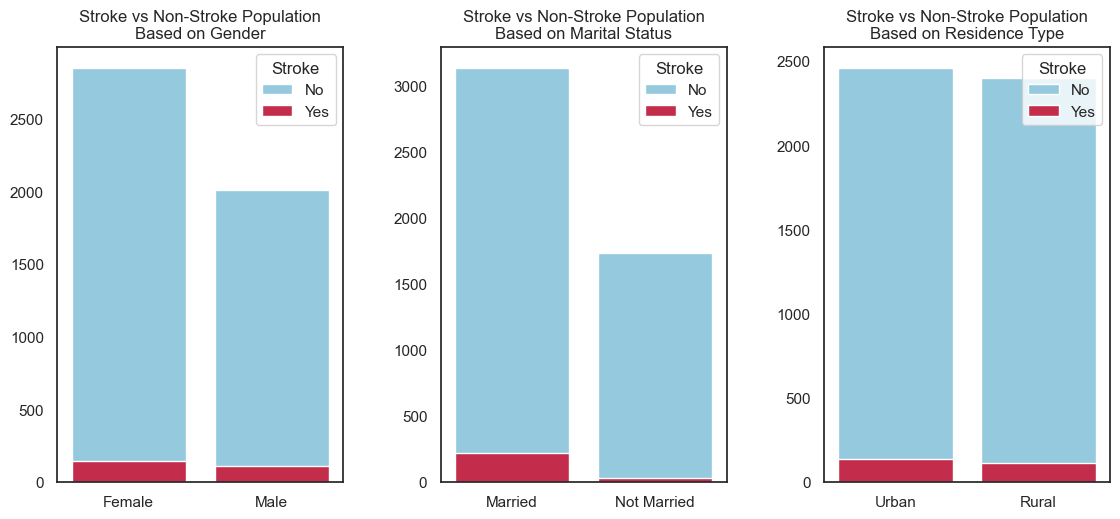

In [16]:
fig, ax = plt.subplots(1,3, figsize=(12,6), dpi=100, facecolor='white')

sns.countplot(x=stroke_n.gender, order=stroke_n.gender.value_counts().index, color='skyblue', label='No', ax=ax[0])
sns.countplot(x=stroke_y.gender, order=stroke_y.gender.value_counts().index, color='crimson', label='Yes', ax=ax[0])
ax[0].set_xlabel(None)
ax[0].set_ylabel(None)
ax[0].set_title('Stroke vs Non-Stroke Population\nBased on Gender')
ax[0].legend(title='Stroke')

sns.countplot(x=stroke_n.ever_married, order=stroke_n.ever_married.value_counts().index, color='skyblue', label='No', ax=ax[1])
sns.countplot(x=stroke_y.ever_married, order=stroke_y.ever_married.value_counts().index, color='crimson', label='Yes', ax=ax[1])
ax[1].set_xlabel(None)
ax[1].set_ylabel(None)
ax[1].set_xticklabels(['Married', 'Not Married'])
ax[1].set_title('Stroke vs Non-Stroke Population\nBased on Marital Status')
ax[1].legend(title='Stroke')

sns.countplot(x=stroke_n.Residence_type, order=stroke_n.Residence_type.value_counts().index, color='skyblue', label='No', ax=ax[2])
sns.countplot(x=stroke_y.Residence_type, order=stroke_y.Residence_type.value_counts().index, color='crimson', label='Yes', ax=ax[2])
ax[2].set_xlabel(None)
ax[2].set_ylabel(None)
ax[2].set_title('Stroke vs Non-Stroke Population\nBased on Residence Type')
ax[2].legend(title='Stroke')

fig.tight_layout(pad=3)
fig.savefig('./images/demographics.svg')
fig.show()

##### *Percentages*

In [17]:
# percentage of people who have been married and have experienced stroke
married_y_perc = len(df[(df.ever_married == 'Yes') & (df.stroke == 1)]) / len(df[df.ever_married == 'Yes']) * 100

# percentage of people who have not been married and have experienced stroke
married_n_perc = len(df[(df.ever_married == 'No') & (df.stroke == 1)]) / len(df[df.ever_married == 'No']) * 100

print('Does marital status affect the occurence of stroke?')
print(f'{married_y_perc:.2}% of the people who are married have experienced stroke.')
print(f'{married_n_perc:.2}% of the people who are not married have experienced stroke.')

Does marital status affect the occurence of stroke?
6.6% of the people who are married have experienced stroke.
1.7% of the people who are not married have experienced stroke.


- As we see, stroke probability for those who have a marriage history is different than for those who don't
- What we observe is that a person who is married (or has been married before) is approx. 4 times more likely to experience stroke

##### *Plot hypertension and heart disease*

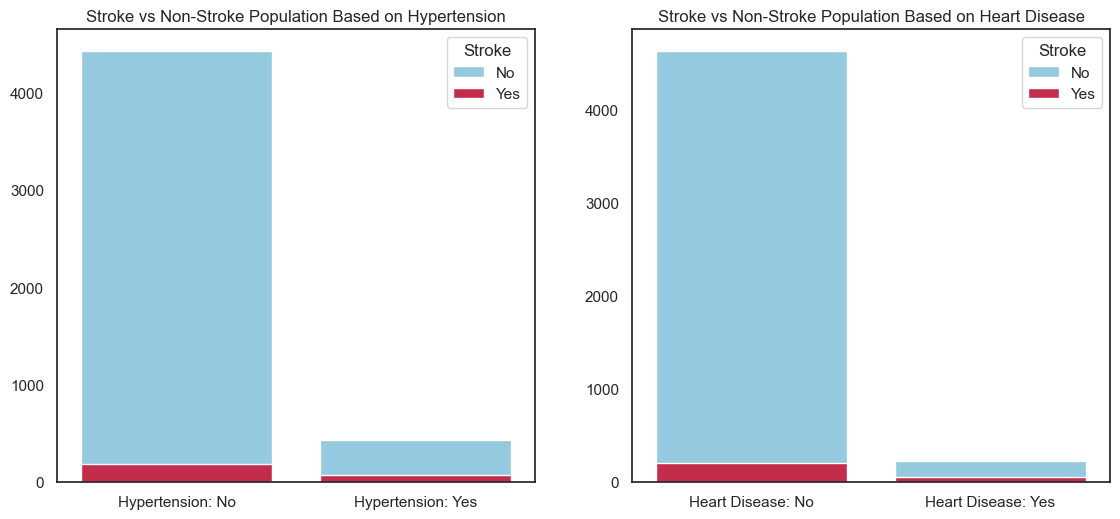

In [18]:
fig, ax = plt.subplots(1,2, figsize=(12,6), dpi=100, facecolor='white')

sns.countplot(x=stroke_n.hypertension, order=stroke_n.hypertension.value_counts().index, color='skyblue', label='No', ax=ax[0])
sns.countplot(x=stroke_y.hypertension, order=stroke_y.hypertension.value_counts().index, color='crimson', label='Yes', ax=ax[0])
ax[0].set_xlabel(None)
ax[0].set_ylabel(None)
ax[0].set_xticklabels(['Hypertension: No', 'Hypertension: Yes'])
ax[0].set_title('Stroke vs Non-Stroke Population Based on Hypertension')
ax[0].legend(title='Stroke')

sns.countplot(x=stroke_n.heart_disease, order=stroke_n.heart_disease.value_counts().index, color='skyblue', label='No', ax=ax[1])
sns.countplot(x=stroke_y.heart_disease, order=stroke_y.heart_disease.value_counts().index, color='crimson', label='Yes', ax=ax[1])
ax[1].set_xlabel(None)
ax[1].set_ylabel(None)
ax[1].set_xticklabels(['Heart Disease: No', 'Heart Disease: Yes'])
ax[1].set_title('Stroke vs Non-Stroke Population Based on Heart Disease')
ax[1].legend(title='Stroke')

fig.tight_layout(pad=3)
fig.savefig('./images/hypertension_heart_disease_stroke.svg')
fig.show()

##### *Percentages*

In [19]:
# percentage of people with no hypertension who have experienced stroke
hypertension_n_perc = len(df[(df.hypertension == 0) & (df.stroke == 1)]) / len(df[df.hypertension == 0]) * 100

# percentage of people with hypertension who have experienced stroke
hypertension_y_perc = len(df[(df.hypertension == 1) & (df.stroke == 1)]) / len(df[df.hypertension == 1]) * 100

print('Does hypertension affect the occurence of stroke?')
print(f'{hypertension_n_perc:.2}% of the people with no hypertension have experienced stroke.')
print(f'{hypertension_y_perc:.3}% of the people with hypertension have experienced stroke.', end='\n\n')

# percentage of people with no heart disease who have experienced stroke
heart_n_perc = len(df[(df.heart_disease == 0) & (df.stroke == 1)]) / len(df[df.heart_disease == 0]) * 100

# percentage of people with heart disease who have experienced stroke
heart_y_perc = len(df[(df.heart_disease == 1) & (df.stroke == 1)]) / len(df[df.heart_disease == 1]) * 100

print('Does heart disease affect the occurence of stroke?')
print(f'{heart_n_perc:.2}% of the people with no heart disease have experienced stroke.')
print(f'{heart_y_perc:.3}% of the people with heart disease have experienced stroke.')

Does hypertension affect the occurence of stroke?
4.0% of the people with no hypertension have experienced stroke.
13.3% of the people with hypertension have experienced stroke.

Does heart disease affect the occurence of stroke?
4.2% of the people with no heart disease have experienced stroke.
17.0% of the people with heart disease have experienced stroke.


- Seems that a person with hypertension is approx. 3 times more likely to experience stroke
- Also, a person with heart disease is approx. 4 times more likely to experience stroke
- Thus, we could say that both those features could be (weak-medium) indicators of a possible stroke incident

##### *Plot age, glucose level and body mass index*

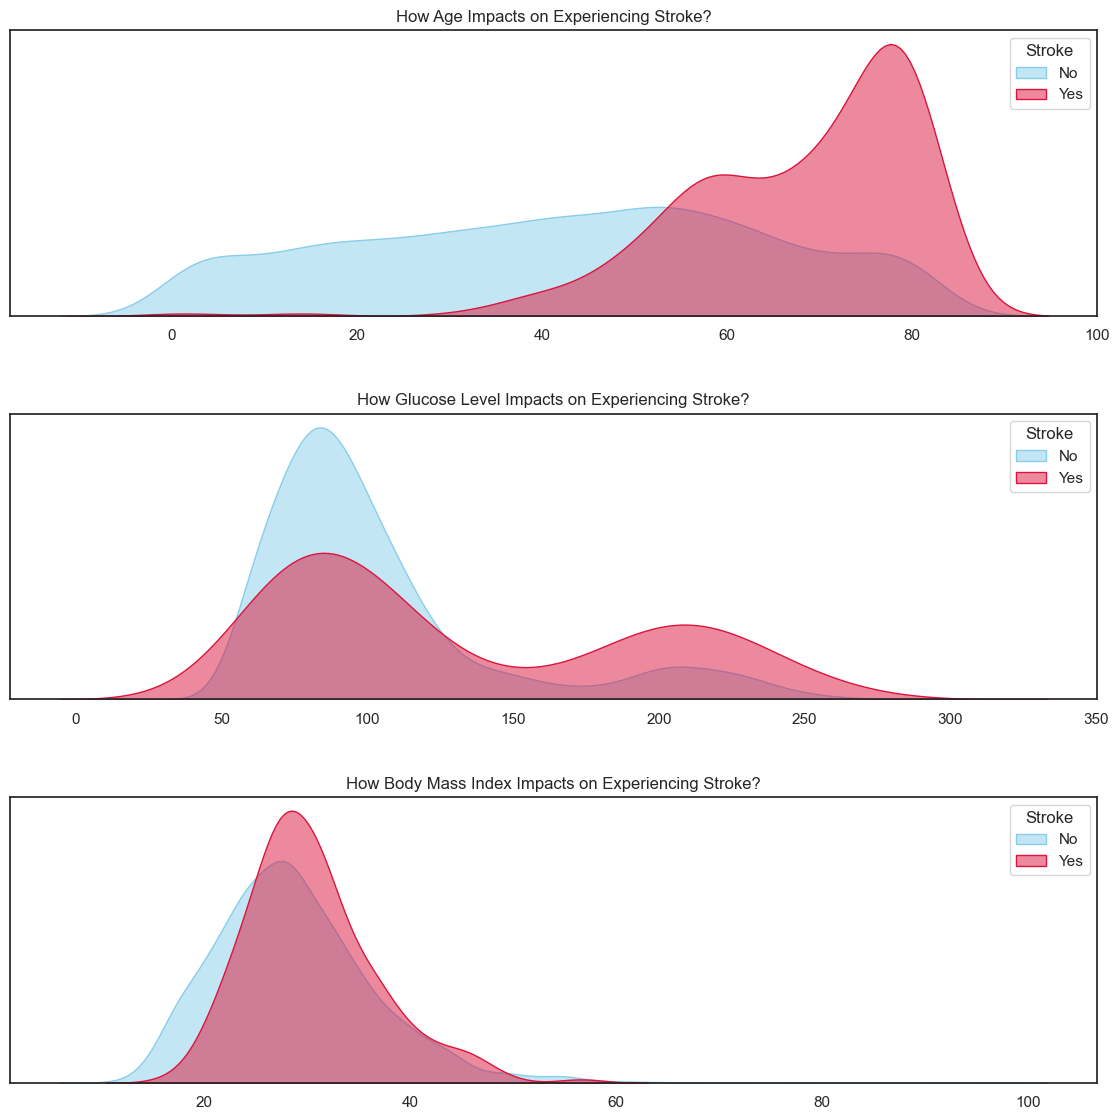

In [20]:
fig, ax = plt.subplots(3, 1, figsize=(12,12), dpi=100, facecolor='white')

sns.kdeplot(x=stroke_n.age, shade=True, color='skyblue', alpha=0.5, label='No', ax=ax[0])
sns.kdeplot(x=stroke_y.age, shade=True, color='crimson', alpha=0.5, label='Yes', ax=ax[0])
ax[0].set_xlabel(None)
ax[0].set_ylabel(None)
ax[0].set_yticks([])
ax[0].legend(title='Stroke')
ax[0].set_title('How Age Impacts on Experiencing Stroke?')

sns.kdeplot(x=stroke_n.avg_glucose_level, shade=True, color='skyblue', alpha=0.5, label='No', ax=ax[1])
sns.kdeplot(x=stroke_y.avg_glucose_level, shade=True, color='crimson', alpha=0.5, label='Yes', ax=ax[1])
ax[1].set_xlabel(None)
ax[1].set_ylabel(None)
ax[1].set_yticks([])
ax[1].legend(title='Stroke')
ax[1].set_title('How Glucose Level Impacts on Experiencing Stroke?')

sns.kdeplot(x=stroke_n.bmi, shade=True, color='skyblue', alpha=0.5, label='No', ax=ax[2])
sns.kdeplot(x=stroke_y.bmi, shade=True, color='crimson', alpha=0.5, label='Yes', ax=ax[2])
ax[2].set_xlabel(None)
ax[2].set_ylabel(None)
ax[2].set_yticks([])
ax[2].legend(title='Stroke')
ax[2].set_title('How Body Mass Index Impacts on Experiencing Stroke?')

fig.tight_layout(pad=3)
fig.savefig('./images/age_glucose_level_bmi_stroke.svg')
fig.show()

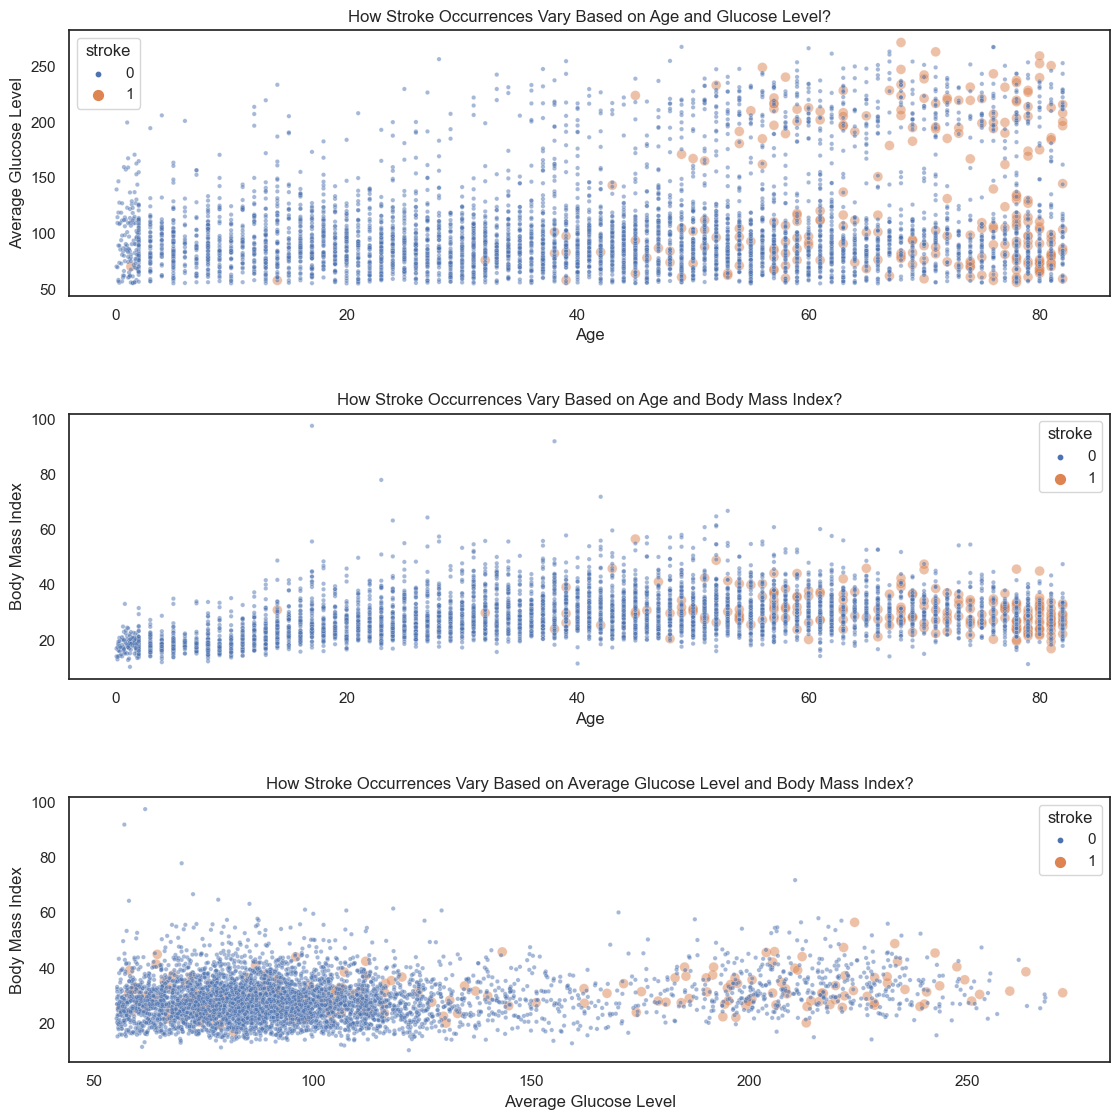

In [21]:
fig, ax = plt.subplots(3, 1, figsize=(12,12), dpi=100, facecolor='white')

sns.scatterplot(x=df.age, y=df.avg_glucose_level, hue=df.stroke, size=df.stroke, sizes=[10,50], alpha=0.5, ax=ax[0])
ax[0].set_xlabel('Age')
ax[0].set_ylabel('Average Glucose Level')
ax[0].set_title('How Stroke Occurrences Vary Based on Age and Glucose Level?')

sns.scatterplot(x=df.age, y=df.bmi, hue=df.stroke, size=df.stroke, sizes=[10,50], alpha=0.5, ax=ax[1])
ax[1].set_xlabel('Age')
ax[1].set_ylabel('Body Mass Index')
ax[1].set_title('How Stroke Occurrences Vary Based on Age and Body Mass Index?')

sns.scatterplot(x=df.avg_glucose_level, y=df.bmi, hue=df.stroke, size=df.stroke, sizes=[10,50], alpha=0.5, ax=ax[2])
ax[2].set_xlabel('Average Glucose Level')
ax[2].set_ylabel('Body Mass Index')
ax[2].set_title('How Stroke Occurrences Vary Based on Average Glucose Level and Body Mass Index?')

fig.tight_layout(pad=3)
fig.savefig('./images/scatter_plots.svg')
fig.show()

- According to the graphs, it's obvious that older people experience strokes much more often than younger ones
- On the other hand, the glucose level and the body mass index do not seem to be quite strong indicators of a possible stroke

### *Pairwise Feature Correlation* <a class='anchor' id='pairwise_feature_correlation'></a>

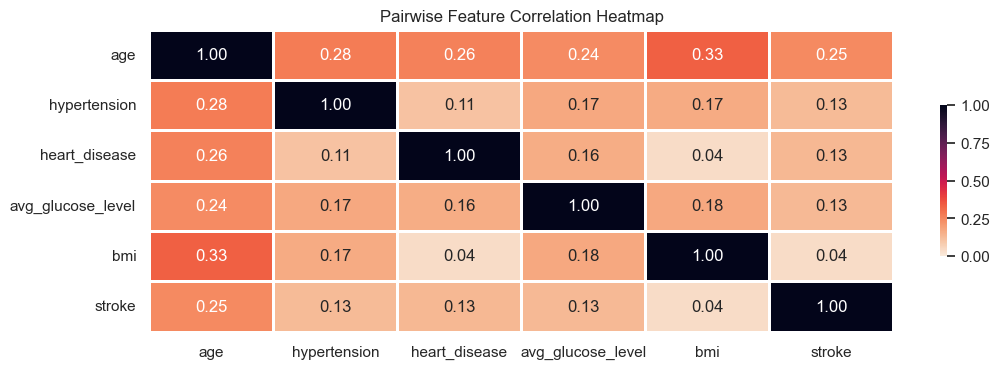

In [22]:
# calculate correlation
corr = df.drop(columns=['id']).corr(method='pearson')

# create figure
plt.figure(figsize=(12,4), dpi=100, facecolor='white')

# initialise plot settings
cmap = sns.color_palette('rocket_r', as_cmap=True)
ticks = [0, 0.25, 0.5, 0.75, 1]

# plot the feature correlation heatmap
sns.heatmap(corr, annot=True, fmt='.2f', vmin=0, cmap=cmap, linewidths=1.0, cbar_kws={'shrink': .5, 'ticks': ticks})

# params
plt.xticks(rotation=0)
plt.title('Pairwise Feature Correlation Heatmap')
plt.savefig('./images/pairwise_feature_correlation.svg')
plt.show()

- We observe that there is no pair of strongly linear correlated features, and all of them are weakly or moderately linear correlated
- The feature that stroke seems to be mostly correlated with is `age`, which is something that we also observed earlier
- Moreover, `age` and `bmi` seem to be moderately linear correlated which makes sense since people tend to exercise less as they grow older

### *Feature Significance* <a class='anchor' id='feature_significance'></a>

- We will use regression to examine the relationship between the independent variables and the dependent variable
- In our case, `stroke` is the dependent variable while the rest of the features are the independent ones
- Some of the features in our data are nominal, and thus we will convert them to dummy before we proceed with the regression

In [23]:
dfs = df.copy() # create a copy of our dataframe

In [24]:
dfs.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,self-employed,Rural,174.12,24.0,never smoked,1


##### *Get dummy variables*

In [25]:
# columns to convert to dummy
to_dummy = dfs.select_dtypes(include='object').columns

# get dummy variables
dfs = pd.get_dummies(dfs, columns=to_dummy, drop_first=True)

# fix column names
dfs.columns = dfs.columns.str.replace(' ', '_').str.replace('-','_')

- For the linear regression model to run properly, all the features need to be standardized
- Thus, before we proceed and run the model, we will standardize our data
- Then, we will fit the linear regression model and see the results

##### *Linear Regression Model*

*Hypothesis Testing*
- **Null Hypothesis (H0):** There is a linear relationship between `feature_name` and `stroke`
- **Alternative Hypothesis (H1):** There is no linear relationship between `feature_name` and `stroke`

*Results*
- We **reject** the Null Hypothesis (H0) if p-value < 0.05
- Thus, any feature with p-value < 0.05 is considered statistically significant

In [26]:
# standardise the data
dfs = dfs.dropna().apply(stats.zscore)

# define formula
formula = 'stroke ~' + '+'.join(dfs.drop(columns=['id', 'stroke']))

# create and fit linear regression model
model = smf.ols(formula, data=dfs.dropna()).fit()

# results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 stroke   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                  0.078
Method:                 Least Squares   F-statistic:                     30.83
Date:                Sun, 19 Jun 2022   Prob (F-statistic):           1.34e-79
Time:                        17:49:50   Log-Likelihood:                -6756.7
No. Observations:                4908   AIC:                         1.354e+04
Df Residuals:                    4893   BIC:                         1.364e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

##### *Statistically significant features*

In [27]:
# get statistically significant features
stat_sig = [x for i, x in enumerate(model.params.index[1:]) if model.pvalues[i+1] <= 0.05]

# print stat sig features
for i, feature in enumerate(stat_sig):
    print(f'0{i+1}: {feature}' if i < 9 else f'{i+1}: {feature}')

01: age
02: hypertension
03: heart_disease
04: avg_glucose_level
05: ever_married_Yes
06: work_type_govt_job
07: work_type_private
08: work_type_self_employed


## Data Preprocessing <a class='anchor' id='data_preprocessing'></a>

- As we discussed earlier, some of the features in our data are nominal
- Therefore, we will convert them into dummy variables, but this time we will use `drop_first=False`

### *One-Hot Encoding* <a class='anchor' id='ohe'></a>

In [28]:
# columns to ohe
to_ohe = df.select_dtypes(include='object').columns

# get dummy variables
df = pd.get_dummies(df, columns=to_ohe, drop_first=False)

# columns
df.columns = df.columns.str.replace(' ', '_').str.replace('-','_').str.lower()

In [29]:
df.head()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_female,gender_male,ever_married_no,...,work_type_children,work_type_govt_job,work_type_private,work_type_self_employed,residence_type_rural,residence_type_urban,smoking_status_unknown,smoking_status_formerly_smoked,smoking_status_never_smoked,smoking_status_smokes
0,9046,67.0,0,1,228.69,36.6,1,0,1,0,...,0,0,1,0,0,1,0,1,0,0
1,51676,61.0,0,0,202.21,NaN,1,1,0,0,...,0,0,0,1,1,0,0,0,1,0
2,31112,80.0,0,1,105.92,32.5,1,0,1,0,...,0,0,1,0,1,0,0,0,1,0
3,60182,49.0,0,0,171.23,34.4,1,1,0,0,...,0,0,1,0,0,1,0,0,0,1
4,1665,79.0,1,0,174.12,24.0,1,1,0,0,...,0,0,0,1,1,0,0,0,1,0


### *Train Test Split* <a class='anchor' id='train_test_split'></a>

In [30]:
# define x, y
x = df.drop(columns=['id','stroke'])
y = df.stroke

# train test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=1)

### *Handle Missing Values* <a class='anchor' id='handle_missing_values'></a>

##### *Check for missing values in our data*

In [31]:
x_train.isna().sum()

age                                 0
hypertension                        0
heart_disease                       0
avg_glucose_level                   0
bmi                               173
gender_female                       0
gender_male                         0
ever_married_no                     0
ever_married_yes                    0
work_type_children                  0
work_type_govt_job                  0
work_type_private                   0
work_type_self_employed             0
residence_type_rural                0
residence_type_urban                0
smoking_status_unknown              0
smoking_status_formerly_smoked      0
smoking_status_never_smoked         0
smoking_status_smokes               0
dtype: int64

- As we saw during EDA step, the distribution of `bmi` is quite right skewed
- We will impute `bmi` missing values using the median of the column

##### *Impute missing values with median*

In [32]:
# initialise imputer
sim = SimpleImputer(strategy='median')

# impute train and test data
x_train.bmi = sim.fit_transform(x_train.bmi.values.reshape(-1,1))
x_test.bmi = sim.transform(x_test.bmi.values.reshape(-1,1))

In [33]:
x_train.isna().sum()

age                               0
hypertension                      0
heart_disease                     0
avg_glucose_level                 0
bmi                               0
gender_female                     0
gender_male                       0
ever_married_no                   0
ever_married_yes                  0
work_type_children                0
work_type_govt_job                0
work_type_private                 0
work_type_self_employed           0
residence_type_rural              0
residence_type_urban              0
smoking_status_unknown            0
smoking_status_formerly_smoked    0
smoking_status_never_smoked       0
smoking_status_smokes             0
dtype: int64

## Feature Engineering <a class='anchor' id='feature_engineering'></a>

### *Feature Scaling* <a class='anchor' id='feature_scaling'></a>

- Some machine learning algorithms will not work properly if the range of values of the data varies widely
- *Feature Scaling* is a method used to normalize the range of independent variables of the data
- Most of the features in our dataset are already normalized, but for those that are not we need to apply scaling

##### *Get the features that need to be scaled*

In [34]:
# get the features that need scaling
to_scale = [feature for feature in x_train.columns if (df[feature].max() > 1)]

# features to scale
print(f'Features to scale: {to_scale}')

Features to scale: ['age', 'avg_glucose_level', 'bmi']


- Now that we have obtained the features, we need to decide what technique we should use to scale them
- In order to have a better understanding on that, let's have a look at their distributions
- Depending whether or not they follow a normal distribution, we will choose the appropriate scaler

##### *Create a function to visualize the distribution of non-normalized features*

In [35]:
def plot_distribution(df, i, feature):
    """
    1. Calculate feature skewness
    2. Run Shapiro Wilk test on a sample to test normality hypothesis
    3. Plot feature distribution
    """
    
    # calculate skewnees
    skewness = df[feature].skew()
    
    # select a sample of 1000 data points
    sample = df[feature].sample(n=1000, random_state=1)
    # test for normal distribution
    shapiro_wilk = shapiro(sample)
    norm_distrib = ('True' if shapiro_wilk.pvalue > 0.05 else 'False')
    
    # print results
    print(f'# {i+1} - {feature}')
    print('='*117)
    print(f'Skewness: {skewness}')
    print('-'*117)
    print(f'Shapiro Wilk test: {shapiro_wilk}')
    print('-'*117)
    print(f'Normal Distribution: {norm_distrib}')
    print('='*117)
    
    # create figure
    plt.figure(figsize=(12,4), dpi=100)
    
    # plot histogram
    sns.histplot(df[feature], kde=True)
    
    # params
    plt.xlabel(None)
    plt.ylabel(None)
    plt.title(f'{feature} distribution', fontsize=14)
    
    plt.tight_layout(pad=3)
    plt.savefig(f'./images/shapiro_wilk_{feature}.svg')
    plt.show()
    
    return None

##### *Shapiro-Wilk Normality Test*

- We will use Shapiro-Wilk test to detect if the population of the features that are being tested is normally distributed

*Hypothesis Testing*

- **Null Hypothesis (H0):** The sample (obtained from `feature_name`) comes from a normal distribution
- **Alternative Hypothesis (H1):** The sample (obtained from `feature_name`) does not come from a normal distribution

*Results*

- We **reject** the Null Hypothesis (H0) if p-value < 0.05

# 1 - age
Skewness: -0.130687537497422
---------------------------------------------------------------------------------------------------------------------
Shapiro Wilk test: ShapiroResult(statistic=0.961765468120575, pvalue=1.6117224335742211e-15)
---------------------------------------------------------------------------------------------------------------------
Normal Distribution: False


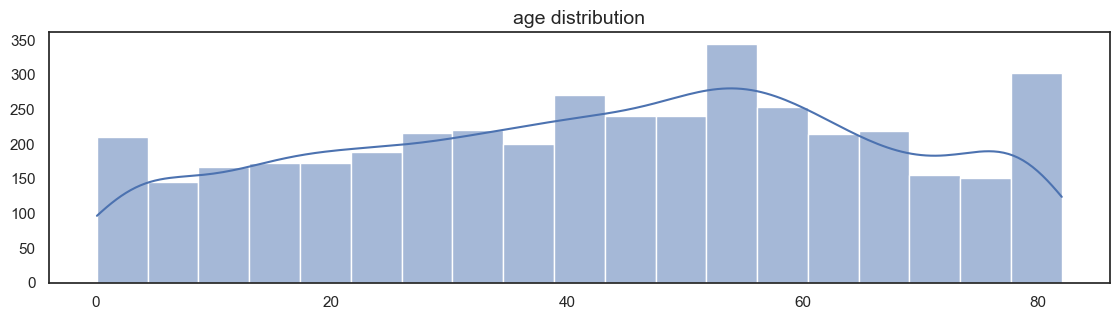

# 2 - avg_glucose_level
Skewness: 1.587963220306541
---------------------------------------------------------------------------------------------------------------------
Shapiro Wilk test: ShapiroResult(statistic=0.8063402771949768, pvalue=5.9466014748573424e-33)
---------------------------------------------------------------------------------------------------------------------
Normal Distribution: False


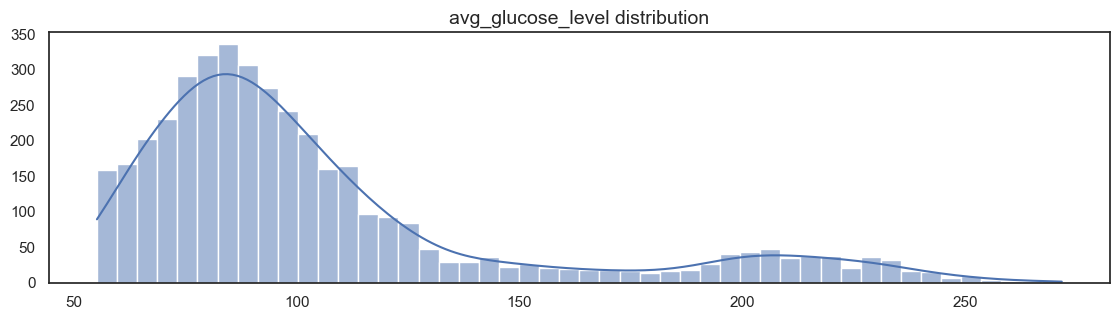

# 3 - bmi
Skewness: 0.8931941429868345
---------------------------------------------------------------------------------------------------------------------
Shapiro Wilk test: ShapiroResult(statistic=0.958818256855011, pvalue=3.6370768897976084e-16)
---------------------------------------------------------------------------------------------------------------------
Normal Distribution: False


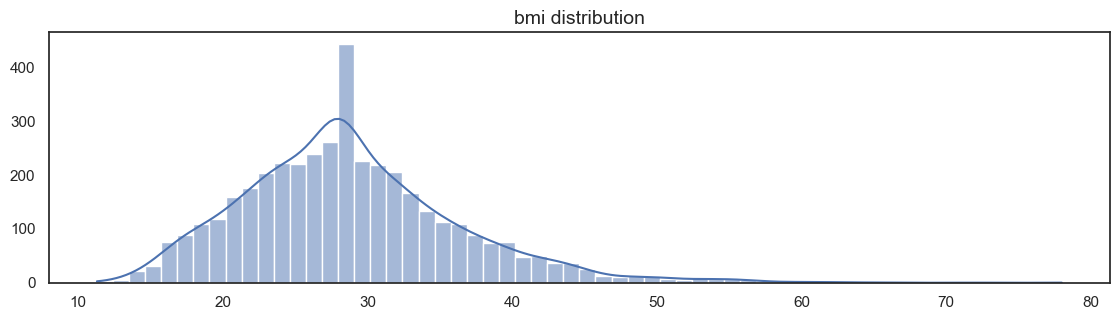

In [36]:
_ = [plot_distribution(x_train, i, feature) for i, feature in enumerate(to_scale)]

- According to the graphs, none of the features seems to follow a normal distribution
- Moreover, the *p-value* obtained from the Shapiro-Wilk test is less than 5%, indicating that none of the samples tested comes from a normal distribution
- Therefore, we **reject** the null hypothesis
- As a result of the previous test, we will scale these features using `MinMaxScaler`

##### *Scale using `MinMaxScaler`*

In [37]:
# initialise scaler
mms = MinMaxScaler()

# scale train and test data
x_train[to_scale] = mms.fit_transform(x_train[to_scale])
x_test[to_scale] = mms.transform(x_test[to_scale])

### *Handle Class Imbalance* <a class='anchor' id='handle_class_imbalance'></a>

In [38]:
y_train.value_counts()

0    3888
1     199
Name: stroke, dtype: int64

- We knew that our dataset is highly imbalanced
- In order to handle that, we will use an over-sampling technique, called `SVMSMOTE`
- This algorithm is a variant of `SMOTE` algorithm which use an `SVM` algorithm to detect sample to use for generating new synthetic samples

##### *Generate new synthetic samples using `SVMSMOTE`*

In [39]:
# initialise SVMSMOTE
svm = SVMSMOTE(random_state=1)

# fit and resample x_train and y_train
xb_train, yb_train = svm.fit_resample(x_train, y_train)

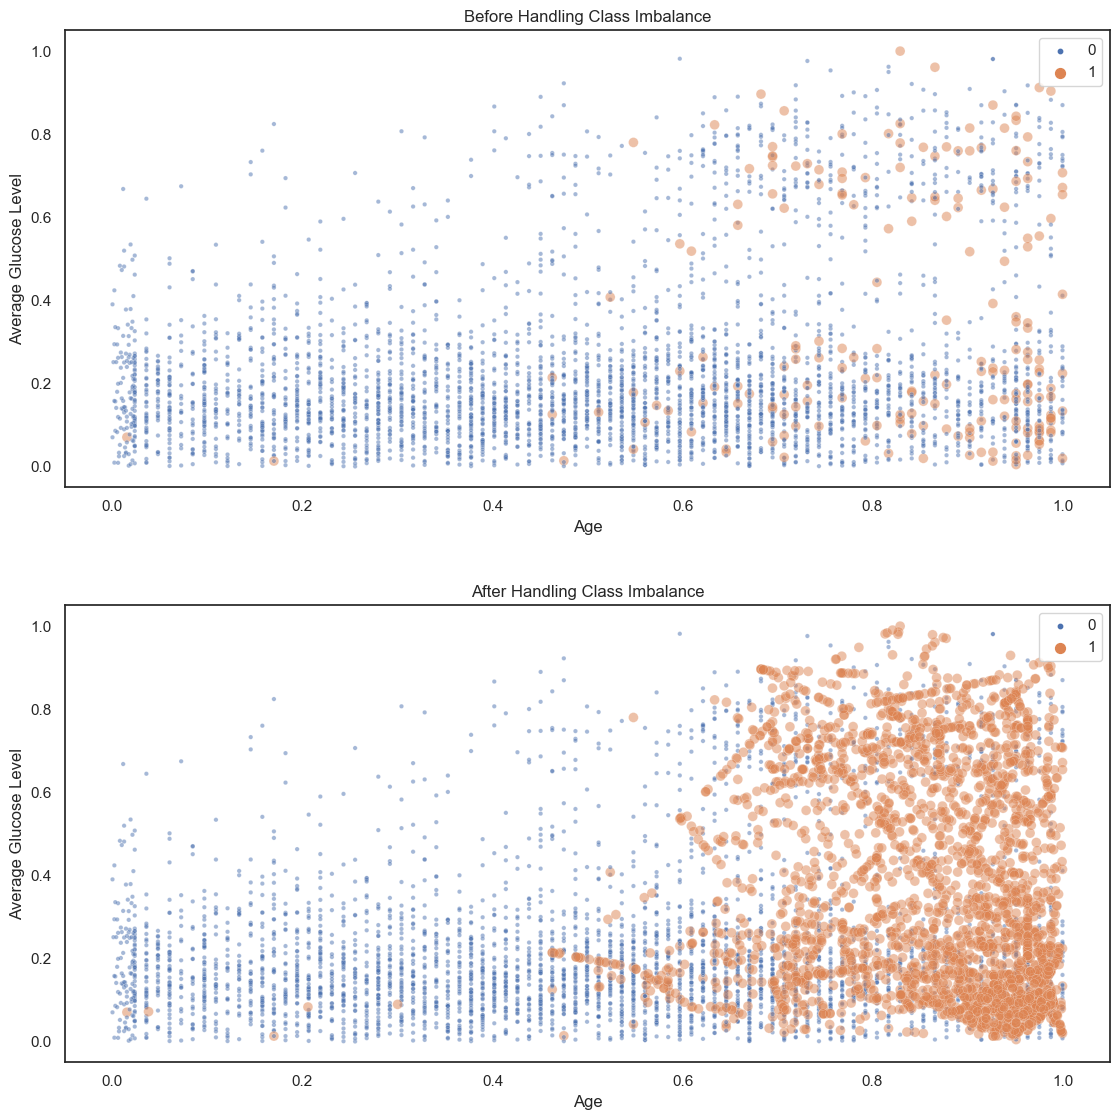

In [40]:
fig, ax = plt.subplots(2,1,figsize=(12,12), dpi=100)

sns.scatterplot(x=x_train.age, y=x_train.avg_glucose_level, hue=y_train.values, size=y_train.values, sizes=[10,50], alpha=0.5, ax=ax[0])
ax[0].set_xlabel('Age')
ax[0].set_ylabel('Average Glucose Level')
ax[0].set_title('Before Handling Class Imbalance')

sns.scatterplot(x=xb_train.age, y=xb_train.avg_glucose_level, hue=yb_train.values, size=yb_train.values, sizes=[10,50], alpha=0.5, ax=ax[1])
ax[1].set_xlabel('Age')
ax[1].set_ylabel('Average Glucose Level')
ax[1].set_title('After Handling Class Imbalance')

fig.tight_layout(pad=3)
fig.savefig('./images/handle_class_imbalance.svg')
fig.show()

## Modeling

### *Cross Validation* <a class='anchor' id='cross_validation'></a>

##### *Function to cross validate multiple models*

In [41]:
def cross_validate_models(x_train, y_train):
    
    # list of classifiers
    models = [['LogisticRegression', LogisticRegression(random_state=1)],
              ['KNN', KNeighborsClassifier()],
              ['DecisionTree', DecisionTreeClassifier(random_state=1)],
              ['RandomForest', RandomForestClassifier(random_state=1)],
              ['ExtraTrees', ExtraTreesClassifier(random_state=1)],
              ['LightGBM', LGBMClassifier(random_state=1)]]
    
    # create a dataframe to store the results
    index = [model[0] for model in models]
    columns = ['Precision', 'Recall', 'F1 Score', 'ROC', 'Accuracy']
    cv_scores = pd.DataFrame(np.nan, index=index, columns=columns)

    # loop through classifiers
    for name, model in models:
        
        # cross validate
        scoring = ['precision', 'recall', 'f1', 'roc_auc', 'accuracy']
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
        scores = cross_validate(model, x_train, y_train, scoring=scoring, cv=cv)
        
        # evaluate
        avg_precision = scores['test_precision'].mean()
        avg_recall = scores['test_recall'].mean()
        avg_f1 = scores['test_f1'].mean()
        avg_roc = scores['test_roc_auc'].mean()
        avg_accuracy = scores['test_accuracy'].mean()
        
        # print results
        # print('='*30)
        # print(f'{name}')
        # print('-'*30)
        # print(f'Precision: {avg_precision}')
        # print(f'Recall:    {avg_recall}')
        # print(f'F1 Score:  {avg_f1}')
        # print(f'ROC:       {avg_roc}')
        # print(f'Accuracy:  {avg_accuracy}\n')
        
        # store the results
        cv_scores.loc[name, 'Precision'] = avg_precision
        cv_scores.loc[name, 'Recall'] = avg_recall
        cv_scores.loc[name, 'F1 Score'] = avg_f1
        cv_scores.loc[name, 'ROC'] = avg_roc
        cv_scores.loc[name, 'Accuracy'] = avg_accuracy

    return cv_scores

# set starting time
start_time = datetime.now()

# run function to get the results
cv_scores = cross_validate_models(xb_train, yb_train)

# set ending time
end_time = datetime.now()

print(f'Running time: {end_time - start_time}')

Running time: 0:00:05.154662


In [42]:
# print results
print(cv_scores.sort_values(by='Recall', ascending=False))

                    Precision    Recall  F1 Score       ROC  Accuracy
ExtraTrees           0.909070  0.946083  0.927199  0.982602  0.939755
RandomForest         0.907781  0.944570  0.925760  0.982778  0.938532
KNN                  0.846699  0.942682  0.892087  0.955829  0.907492
LightGBM             0.938291  0.933638  0.935926  0.986837  0.948165
DecisionTree         0.868544  0.891787  0.879988  0.899854  0.901376
LogisticRegression   0.777998  0.818257  0.797342  0.908898  0.831346


### *GridSearchCV* <a class='anchor' id='grid_search_cv'></a>

##### *Function to find the best hyperparameters*

In [43]:
def grid_search_tuning_models(x_train, y_train):
    
    # list of classifiers
    models = [['LogisticRegression', LogisticRegression(random_state=1)],
              ['KNN', KNeighborsClassifier()],
              ['DecisionTree', DecisionTreeClassifier(random_state=1)],
              ['RandomForest', RandomForestClassifier(random_state=1)],
              ['ExtraTrees', ExtraTreesClassifier(random_state=1)],
              ['LightGBM', LGBMClassifier(random_state=1)]]
    
    # list with hyperparameters to test
    param_grid = [['LogisticRegression', {'penalty': ['l1','l2'], 'solver': ['lbfgs','liblinear'], 'max_iter': range(100,1300,300)}],
                  ['KNN', {'n_neighbors': [5,10,50,100], 'weights': ['uniform','distance'], 'metric': ['euclidean','manhattan','minkowski']}],
                  ['DecisionTree', {'criterion': ['gini','entropy']}],
                  ['RandomForest', {'n_estimators': range(100,1300,300), 'criterion': ['gini','entropy']}],
                  ['ExtraTrees', {'n_estimators': range(100,1300,300), 'criterion': ['gini','entropy']}],
                  ['LightGBM', {'n_estimators': range(100,1300,300)}]]
    
    # create a dataframe to store the results
    gs_scores = pd.DataFrame(np.nan, index=[model[0] for model in models], columns=['Recall'])

    # loop through classifiers
    for index, model in enumerate(models):
        
        # gridsearchCV
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
        grid = GridSearchCV(model[1], param_grid[index][1], scoring='recall', cv=cv)
        grid.fit(x_train, y_train)
        
        # evaluate
        best_score = grid.best_score_
        best_params = grid.best_params_
        best_estimator = grid.best_estimator_
        
        # print results
        print('='*93)
        print(f'{model[0]}')
        print('-'*93)
        print(f'Best grid score: {best_score}')
        print(f'Best grid params: {best_params}')
        print(f'Best estimator: {best_estimator}', end='\n\n')
        
        # store the results
        gs_scores.loc[model[0], 'Recall'] = best_score
    
    return gs_scores

# set starting time
start_time = datetime.now()

# run function to get the results
gs_scores = grid_search_tuning_models(xb_train, yb_train)

# set ending time
end_time = datetime.now()

print(f'Running time: {end_time - start_time}')

LogisticRegression
---------------------------------------------------------------------------------------------
Best grid score: 0.8208940056141847
Best grid params: {'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}
Best estimator: LogisticRegression(random_state=1, solver='liblinear')

KNN
---------------------------------------------------------------------------------------------
Best grid score: 0.9547518032903387
Best grid params: {'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}
Best estimator: KNeighborsClassifier(metric='manhattan', weights='distance')

DecisionTree
---------------------------------------------------------------------------------------------
Best grid score: 0.8917869452439326
Best grid params: {'criterion': 'gini'}
Best estimator: DecisionTreeClassifier(random_state=1)

RandomForest
---------------------------------------------------------------------------------------------
Best grid score: 0.9475890985324946
Best grid params: {'criter

### *Predictions* <a class='anchor' id='predictions'></a>

##### *Function to make predictions on test set*

In [44]:
def make_predictions(x_train, x_test, y_train, y_test):

    # list of the best performing classifiers
    models = [['LogisticRegression', LogisticRegression(random_state=1, solver='liblinear')],
              ['KNN', KNeighborsClassifier(metric='manhattan', weights='distance')],
              ['DecisionTree', DecisionTreeClassifier(random_state=1)],
              ['RandomForest', RandomForestClassifier(criterion='entropy', n_estimators=400, random_state=1)],
              ['ExtraTrees', ExtraTreesClassifier(criterion='entropy', n_estimators=400, random_state=1)],
              ['LightGBM', LGBMClassifier(n_estimators=700, random_state=1)]]

    # create a dataframe to store the results
    index = [model[0] for model in models]
    columns = ['Precision', 'Recall', 'F1 Score', 'ROC', 'Accuracy']
    prediction_scores = pd.DataFrame(np.nan, index=index, columns=columns)
    
    # loop through classifiers
    for name, model in models:
        
        # fit and predict
        model.fit(x_train, y_train)
        preds = model.predict(x_test)
        
        # evaluate
        precision = precision_score(y_test, preds)
        recall = recall_score(y_test, preds)
        f1 = f1_score(y_test, preds)
        roc = roc_auc_score(y_test, preds)
        accuracy = accuracy_score(y_test, preds)
        tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
        
        # print results
        print('='*53)
        print(f'{name}')
        print('-'*53)
        # print(f'Precision: {precision}')
        # print(f'Recall:    {recall}')
        # print(f'F1 Score:  {f1}')
        # print(f'ROC:       {roc}')
        # print(f'Accuracy:  {accuracy}')
        # print(f'{confusion_matrix(y_test, preds)}')
        print(f'True Positives:  {tp}')
        print(f'True Negatives:  {tn}')
        print(f'False Positives: {fp}')
        print(f'False Negatives: {fn}')
        print('-'*53)
        print(f'{classification_report(y_test, preds)}', end='\n\n')
        
        # store results
        prediction_scores.loc[name, 'Precision'] = precision
        prediction_scores.loc[name, 'Recall'] = recall
        prediction_scores.loc[name, 'F1 Score'] = f1
        prediction_scores.loc[name, 'ROC'] = roc
        prediction_scores.loc[name, 'Accuracy'] = accuracy

    return prediction_scores

# set starting time
start_time = datetime.now()

# run final predictions
final_predictions = make_predictions(xb_train, x_test, yb_train, y_test)

# set ending time
end_time = datetime.now()

print(f'Running time: {end_time - start_time}')

LogisticRegression
-----------------------------------------------------
True Positives:  30
True Negatives:  828
False Positives: 144
False Negatives: 20
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.85      0.91       972
           1       0.17      0.60      0.27        50

    accuracy                           0.84      1022
   macro avg       0.57      0.73      0.59      1022
weighted avg       0.94      0.84      0.88      1022


KNN
-----------------------------------------------------
True Positives:  14
True Negatives:  869
False Positives: 103
False Negatives: 36
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.89      0.93       972
           1       0.12      0.28      0.17        50

    accuracy                           0.86      1022
   macro avg       0.54      0.59      0.55      10

In [45]:
# print results
print(final_predictions.sort_values(by='Recall', ascending=False))

                    Precision  Recall  F1 Score       ROC  Accuracy
LogisticRegression   0.172414    0.60  0.267857  0.725926  0.839530
KNN                  0.119658    0.28  0.167665  0.587016  0.863992
DecisionTree         0.125000    0.28  0.172840  0.589588  0.868885
ExtraTrees           0.155844    0.24  0.188976  0.586564  0.899217
RandomForest         0.149254    0.20  0.170940  0.570679  0.905088
LightGBM             0.146341    0.12  0.131868  0.541996  0.922701


## Conclusion <a class='anchor' id='conclusion'></a>

In order to choose the model that meets our needs, we need to ask ourselves "*why should I predict this?*".

<p style='text-align: justify;'>
I suppose, in this case, the answer is that we would like to offer some kind of medical advice and/or preventative treatment to those who we predict are more likely to have a stroke. In other words, we want a model that can predict as many <i>true positives</i> and as few <i>false negatives</i> as possible. Therefore, we should look for a model with high recall.
</p>

That being said, the model that yields the highest recall is **Logistic Regression**, achieving a value of 60%.

---

*Thank you!*

---